This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# DATATEST of GaPSE

This notebook provides the code necessary to compute all the files stored in the `../test/datatest` directory. They are used for the unit and integration tests of the code.

## Background Framework

In [1]:
PATH_TO_GAPSE = "../";

In [2]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [3]:
using Plots, DelimitedFiles, Printf

In [4]:
const FILE_F_MAP = PATH_TO_GAPSE * "test/datatest/F_REFERENCE_pi2.txt"
const FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
const FILE_IF_MAP = PATH_TO_GAPSE * "test/datatest/IntegrF_REFERENCE_pi2.txt"
const FILE_ILN = PATH_TO_GAPSE * "test/datatest/table_Iln.txt"
const FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

const Z_MIN = 0.05
const Z_MAX = 0.20
const S_MIN = 148.1920001343431
const S_MAX = 571.7022420911966
const S_EFF = 435.37470960794167
const Z_EFF = 0.15045636097417317
const VOLUME = 3.845366167993746e8
const HUBBLE_0 = 1e5 / 299792458.0

const PARAMS = GaPSE.CosmoParams(Z_MIN, Z_MAX, π / 2.0;
     Ω_b=0.0489, Ω_cdm=0.251020, h_0=0.7, s_lim=1e-2,
     IPS_opts=Dict(
          :fit_left_min => 1e-6, :fit_left_max => 3e-6,
          :fit_right_min => 1e1, :fit_right_max => 2e1,
     ),
     IPSTools_opts=Dict(
          :N => 1024, :fit_min => 0.05, :fit_max => 0.5,
          :con => true, :k_min => 1e-8, :k_max => 10.0
    ),
     WFI_opts = Dict(:llim => 0.0, :rlim => Inf, :N => 1000,
          :trap => true, :rtol => 1e-2, :atol => 0.0,
          :ss_start => 0.0, :ss_step => 21.768735478453323,
          :ss_stop => 0.0)
)
const COSMO = GaPSE.Cosmology(PARAMS, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

#=
common_kwargs = Dict(
     :pr => false,
     :use_windows => false,
     :enhancer => 1e8, :N_μs => 30,
     :μ_atol => 0.0, :μ_rtol => 1e-2,
     :N_log => 100,
);

spec_effect = [
     "auto_lensing", "auto_integratedgp",
     "lensing_doppler", "doppler_lensing",
     "doppler_integratedgp", "integratedgp_doppler",
     "lensing_localgp", "localgp_lensing",
     "lensing_integratedgp", "integratedgp_lensing",
     "localgp_integratedgp", "integratedgp_localgp",
];

specific_kwargs = [effect ∈ spec_effect ? Dict(
     :en => 1e12, :N_χs => 30) : nothing for effect in GaPSE.GR_EFFECTS_LD]

joint_kwargs = [isnothing(spec) ? common_kwargs : merge(common_kwargs, spec)
                for spec in specific_kwargs];
=#

Main.GaPSE.Cosmology(Main.GaPSE.InputPS(0.9599998007678217, 3.0123089778963984e6, 0.0, 1.0e-6, Spline1D(knots=[1.0e-6,1.02329e-6 … 19.7242,20.1837] (1460 elements), k=3, extrapolation="error", residual=0.0), -2.6531284143857454, 68.30720789490483, 0.0, 20.0), Main.GaPSE.EPLs(-0.04194951401921344, 69.58813284371618, 0.0, 0.001, Spline1D(knots=[0.001,0.00104131 … 9.41094e5,9.79966e5] (1022 elements), k=3, extrapolation="error", residual=0.0), -0.007145448938534893, 2.8961464294439625e-16, 0.0, 979965.8407585004), Main.GaPSE.CosmoParams(0.05, 0.2, 1.5707963267948966, 0.0489, 0.25102, 0.29992, 0.7, 1.0, 0.0, 0.0, 0.01, Dict(:fit_left_min => 1.0e-6, :fit_right_min => 10.0, :fit_left_max => 3.0e-6, :fit_right_max => 20.0), Dict{Symbol, Real}(:k_max => 10.0, :fit_max => 0.5, :N => 1024, :con => true, :k_min => 1.0e-8, :fit_min => 0.05), Dict{Symbol, Real}(:ss_step => 21.768735478453323, :N => 1000, :rtol => 0.01, :llim => 0.0, :atol => 0.0, :rlim => Inf, :ss_stop => 0.0, :trap => true, :ss_st

## F_map tests

In [5]:
kwargs_map_F_hcub = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-8, 
     :rtol => 1e-2, :atol => 1e-3, :pr => true,
);

kwargs_map_F_trapz = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-8, 
     :N => 1000, :pr => true,
);

In [6]:
first_output = "test/datatest/F_first_method.txt"
second_output = "test/datatest/F_second_method.txt"

calc_xs = [x for x in 0:0.25:3]
calc_μs = vcat([-1.0, -0.98, -0.95], [μ for μ in -0.9:0.1:0.9], [0.95, 0.98, 1.0])

GaPSE.print_map_F(PATH_TO_GAPSE * first_output, 0.25, 0.25;
    x1 = 0, x2 = 3, μ1 = -1, μ2 = 1, 
    trapz = true, Fmap_opts = kwargs_map_F_trapz)
GaPSE.print_map_F(PATH_TO_GAPSE * second_output, calc_xs, calc_μs;
    trapz = true, Fmap_opts = kwargs_map_F_trapz)

window F evaluation: 100%|██████████████████████████████| Time: 0:00:08
window F evaluation: 100%|██████████████████████████████| Time: 0:00:16


## IntegratedF_map tests

In [7]:
kwargs_map_F_int = Dict(
    :ss_start => 100, :ss_stop => 500, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 300, :pr => true,
);

kwargs_F_int_quad = Dict(
    :llim => kwargs_map_F_int[:llim], 
    :rlim => kwargs_map_F_int[:rlim], 
    :rtol => kwargs_map_F_int[:rtol], 
    :atol => kwargs_map_F_int[:atol],
)

kwargs_F_int_trap = Dict(
    :llim => kwargs_map_F_int[:llim], 
    :rlim => kwargs_map_F_int[:rlim], 
    :N => kwargs_map_F_int[:N], 
)

windF = GaPSE.WindowF(FILE_F_MAP); 

calc_μs = vcat([-1.0, -0.98, -0.95], 
    [μ for μ in -0.9:0.3:0.9], 
    [0.95, 0.98, 1.0]);

In [8]:
calc_ss = [100, 150, 200, 250]
calc_μs = [0.0, 0.8, -0.8]
s_min, s_max = 148.1920001465757, 571.7022420258767
z_min, z_max = 0.05, 0.20

println("integrated_F_quadgk: ")
for μ in calc_μs, s in calc_ss
    IF = GaPSE.integrated_F_quadgk(s, μ, s_min, s_max, windF; 
          kwargs_F_int_quad...)
    res = @sprintf("%.5e", IF)
    println("s = $s, \t μ = $μ, \t IF = $res") 
end
println("\n integrated_F_trap: ")
for μ in calc_μs, s in calc_ss
    IF = GaPSE.integrated_F_trapz(s, μ, s_min, s_max, windF; 
          kwargs_F_int_trap...)
    res = @sprintf("%.5e", IF)
    println("s = $s, \t μ = $μ, \t IF = $res") 
end

integrated_F_quadgk: 
s = 100, 	 μ = 0.0, 	 IF = 2.12335e+09
s = 150, 	 μ = 0.0, 	 IF = 1.93936e+09
s = 200, 	 μ = 0.0, 	 IF = 1.68321e+09
s = 250, 	 μ = 0.0, 	 IF = 1.45684e+09
s = 100, 	 μ = 0.8, 	 IF = 1.42493e+09
s = 150, 	 μ = 0.8, 	 IF = 1.06046e+09
s = 200, 	 μ = 0.8, 	 IF = 7.53131e+08
s = 250, 	 μ = 0.8, 	 IF = 4.82146e+08
s = 100, 	 μ = -0.8, 	 IF = 2.14873e+09
s = 150, 	 μ = -0.8, 	 IF = 2.08741e+09
s = 200, 	 μ = -0.8, 	 IF = 1.98355e+09
s = 250, 	 μ = -0.8, 	 IF = 1.93041e+09

 integrated_F_trap: 
s = 100, 	 μ = 0.0, 	 IF = 2.15022e+09
s = 150, 	 μ = 0.0, 	 IF = 1.93769e+09
s = 200, 	 μ = 0.0, 	 IF = 1.68718e+09
s = 250, 	 μ = 0.0, 	 IF = 1.41394e+09
s = 100, 	 μ = 0.8, 	 IF = 1.44814e+09
s = 150, 	 μ = 0.8, 	 IF = 1.04627e+09
s = 200, 	 μ = 0.8, 	 IF = 7.29342e+08
s = 250, 	 μ = 0.8, 	 IF = 4.84891e+08
s = 100, 	 μ = -0.8, 	 IF = 2.18180e+09
s = 150, 	 μ = -0.8, 	 IF = 2.05673e+09
s = 200, 	 μ = -0.8, 	 IF = 1.93539e+09
s = 250, 	 μ = -0.8, 	 IF = 1.90523e+09


In [9]:
GaPSE.print_map_IntegratedF(
    PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt", 
    PATH_TO_GAPSE * "test/datatest/WindowFIntegrated/IntF_trap_1.txt", 
    148.1920001465757, 571.7022420258767, calc_μs;
    trap = true, kwargs_map_F_int...
)

GaPSE.print_map_IntegratedF(
    PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt", 
    PATH_TO_GAPSE * "test/datatest/WindowFIntegrated/IntF_quad_1.txt",
    148.1920001465757, 571.7022420258767, calc_μs;
    trap = false, kwargs_map_F_int...
)

LoadError: AssertionError: μs must be a float vector of increasing values!

In [10]:
GaPSE.print_map_IntegratedF(
    PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt", 
    PATH_TO_GAPSE * "test/datatest/WindowFIntegrated/IntF_trap_2.txt", 
    0.05, 0.20, calc_μs, FILE_BACKGROUND;
    trap = true, kwargs_map_F_int...
)

GaPSE.print_map_IntegratedF(
    PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt", 
    PATH_TO_GAPSE * "test/datatest/WindowFIntegrated/IntF_quad_2.txt",
    0.05, 0.20, calc_μs, FILE_BACKGROUND;
    trap = false, kwargs_map_F_int...
)

LoadError: AssertionError: μs must be a float vector of increasing values!

## LD_XiMultipoles

In [11]:
name_effect = "auto_doppler"
func_effect = GaPSE.ξ_LD_Doppler

kwargs =  Dict(
          :use_windows => false,
          :enhancer => 1e8, :N_μs => 200,
          :μ_atol => 0.0, :μ_rtol => 1e-2
     )

for L in [0,1,2,3,4]
    GaPSE.print_map_ξ_LD_multipole(COSMO, 
        PATH_TO_GAPSE * "test/datatest/LD_doppler_multipoles/xi_LD_" * 
            name_effect * "_L$L" * ".txt",
        name_effect, 
        10 .^ range(-1, 3, length=300); 
        L=L, kwargs...)
end

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00



time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.63688 


time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.07919 


time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.08915 


time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.09402 


time needed for map_ξ_LD_multipole for auto_doppler [in s] = 0.09311 



In [12]:
kwargs = Dict(
          :use_windows => false,
          :pr => false,
          :enhancer => 1e8, :N_μs => 30,
          :μ_atol => 0.0, :μ_rtol => 1e-2,
          :N_log => 1000
     )

GaPSE.print_map_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/LD_doppler_multipoles/xi_LD_auto_doppler_L0_first.txt", 
    "auto_doppler",  nothing;
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/LD_doppler_multipoles/xi_LD_auto_doppler_L0_second.txt", 
    "auto_doppler",  10 .^ range(0, 3, length = 344);
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/LD_doppler_multipoles/xi_LD_auto_doppler_L0_third.txt", 
    "auto_doppler",  10 .^ range(0, 3, length = 344);
    s1 = COSMO.s_eff - 65.0, L = 0, kwargs...)

## LD_SumXiMultipoles specific ss

In [13]:
kwargs = Dict(
    :L => 0, :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/LD_SumXiMultipoles/"*
    "map_sum_xi_LD_L0" * "_noF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:03
auto_localgp, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:01
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 


time needed for map_sum_ξ_LD_multipole [in s] = 14.50211 



In [14]:
kwargs = Dict(
    :L => 0, :use_windows => true,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/LD_SumXiMultipoles/"*
    "map_sum_xi_LD_L0" * "_withF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:02
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:00
localgp_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_localgp, L=0: 100%|████████████████████████| Time: 0:00:00



time needed for map_sum_ξ_LD_multipole [in s] = 6.25050 



## LD_SumXiMultipoles all xis

In [15]:
KWARGS_LD = Dict(
    :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 30,
    :N_log => 100,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/LD_SumXiMultipoles/"*
    "map_sum_xi_LD_L0" * "_noF.txt",
    10 .^ range(-1, 3, length = KWARGS_LD[:N_log]); 
    L=0, KWARGS_LD...)

auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:11
auto_localgp, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:01
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:01
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:01
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:02
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:02
localgp_integratedgp, L=0: 100%|████████████████████████| Time: 


time needed for map_sum_ξ_LD_multipole [in s] = 29.07498 



## PPDoppler

In [16]:
kwargs_xis_PP = Dict(
     :pr => false, :enhancer => 1e8, 
     :μ_atol => 0.0, :μ_rtol => 1e-2,
     :N_log => 100, 
);
common = PATH_TO_GAPSE * "test/datatest/pp_doppler/"

GaPSE.print_map_ξ_PPD_multipole(COSMO, common*"xi_ppdoppler_noF_L0.txt",
    10 .^ range(0,3,length=300); use_windows = false, 
    L = 0, kwargs_xis_PP...);
GaPSE.print_map_ξ_PPD_multipole(COSMO, common*"xi_ppdoppler_noF_L2.txt", 
    10 .^ range(0,3,length=300); use_windows = false, 
    L = 2, kwargs_xis_PP...);

GaPSE.print_map_ξ_PPD_multipole(COSMO, common*"xi_ppdoppler_withF_L0.txt", 
    10 .^ range(0,3,length=300); use_windows = true, 
    L = 0, kwargs_xis_PP...);
GaPSE.print_map_ξ_PPD_multipole(COSMO, common*"xi_ppdoppler_withF_L2.txt", 
    10 .^ range(0,3,length=300); use_windows = true, 
    L = 2, kwargs_xis_PP...);

## GNC_XiMultipoles

In [17]:
name_effect = "auto_doppler"
func_effect = GaPSE.ξ_GNC_Doppler

kwargs =  Dict(
          :use_windows => false,
          :enhancer => 1e8, :N_μs => 200,
          :μ_atol => 0.0, :μ_rtol => 1e-2
     )

for L in [0,1,2,3,4]
    GaPSE.print_map_ξ_GNC_multipole(COSMO, 
        PATH_TO_GAPSE * "test/datatest/GNC_doppler_multipoles/xi_GNC_" * 
            name_effect * "_L$L" * ".txt",
        name_effect, 
        10 .^ range(-1, 3, length=300); 
        L=L, kwargs...)
end

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_doppler, L=1: 100%|████████████████████████████████| Time: 0:00:00
auto_doppler, L=3: 100%|████████████████████████████████| Time: 0:00:00



time needed for map_ξ_GNC_multipole for auto_doppler [in s] = 0.96640 


time needed for map_ξ_GNC_multipole for auto_doppler [in s] = 0.10827 


time needed for map_ξ_GNC_multipole for auto_doppler [in s] = 0.09250 


time needed for map_ξ_GNC_multipole for auto_doppler [in s] = 0.16619 


time needed for map_ξ_GNC_multipole for auto_doppler [in s] = 0.08955 



In [18]:
kwargs = Dict(
          :use_windows => false,
          :pr => false,
          :enhancer => 1e8, :N_μs => 30,
          :μ_atol => 0.0, :μ_rtol => 1e-2,
          :N_log => 1000
     )

GaPSE.print_map_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNC_doppler_multipoles/xi_GNC_auto_doppler_L0_first.txt", 
    "auto_doppler",  nothing;
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNC_doppler_multipoles/xi_GNC_auto_doppler_L0_second.txt", 
    "auto_doppler",  10 .^ range(0, 3, length = 344);
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNC_doppler_multipoles/xi_GNC_auto_doppler_L0_third.txt", 
    "auto_doppler",  10 .^ range(0, 3, length = 344);
    s1 = COSMO.s_eff - 65.0, L = 0, kwargs...)

## GNC_SumXiMultipoles specific ss

In [19]:
kwargs = Dict(
    :L => 0, :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNC_SumXiMultipoles/"*
    "map_sum_xi_GNC_L0" * "_noF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

auto_newton, L=0: 100%|█████████████████████████████████| Time: 0:00:00
auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:04
auto_localgp, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:01
newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
doppler_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:01
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_localgp, L=0: 100%|██████████████████████████████| Time: 0:00:00
localgp_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:00
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:00
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole [in s] = 22.68011 



In [20]:
kwargs = Dict(
    :L => 0, :use_windows => true,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNC_SumXiMultipoles/"*
    "map_sum_xi_GNC_L0" * "_withF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:02
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:00
newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:00
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:00
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole [in s] = 7.54003 



## GNC_SumXiMultipoles all xis

In [21]:
KWARGS_GNC = Dict(
    :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 30,
    :N_log => 100,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNC_SumXiMultipoles/"*
    "map_sum_xi_GNC_L0" * "_noF.txt",
    10 .^ range(-1, 3, length = KWARGS_GNC[:N_log]); 
    L=0, KWARGS_GNC...)

auto_newton, L=0: 100%|█████████████████████████████████| Time: 0:00:00
auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:10
auto_localgp, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:01
newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
doppler_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:03
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:02
newton_localgp, L=0: 100%|██████████████████████████████| Time: 0:00:00
localgp_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:01
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:01
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:01
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole [in s] = 40.63923 



## GNCxLD_XiMultipoles and LDxGNC_XiMultipoles

In [22]:
name_effect = "localgp_doppler"
func_effect = GaPSE.ξ_GNCxLD_LocalGP_Doppler

kwargs =  Dict(
          :use_windows => false,
          :enhancer => 1e8, :N_μs => 200,
          :μ_atol => 0.0, :μ_rtol => 1e-2
     )

for L in [0,1,2,3,4]
    GaPSE.print_map_ξ_GNCxLD_multipole(COSMO, 
        PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_GNCxLD_" * 
            name_effect * "_L$L" * ".txt",
        name_effect, 
        10 .^ range(-1, 3, length=300); 
        L=L, kwargs...)
end

localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:01
localgp_doppler, L=1: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=2: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=3: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=4: 100%|█████████████████████████████| Time: 0:00:00



time needed for map_ξ_GNCxLD_multipole for localgp_doppler [in s] = 1.11618 


time needed for map_ξ_GNCxLD_multipole for localgp_doppler [in s] = 0.12817 


time needed for map_ξ_GNCxLD_multipole for localgp_doppler [in s] = 0.12516 


time needed for map_ξ_GNCxLD_multipole for localgp_doppler [in s] = 0.14260 


time needed for map_ξ_GNCxLD_multipole for localgp_doppler [in s] = 0.15099 



In [23]:
name_effect = "localgp_doppler"
func_effect = GaPSE.ξ_LDxGNC_LocalGP_Doppler

kwargs =  Dict(
          :use_windows => false,
          :enhancer => 1e8, :N_μs => 200,
          :μ_atol => 0.0, :μ_rtol => 1e-2
     )

for L in [0,1,2,3,4]
    GaPSE.print_map_ξ_LDxGNC_multipole(COSMO, 
        PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_LDxGNC_" * 
            name_effect * "_L$L" * ".txt",
        name_effect, 
        10 .^ range(-1, 3, length=300); 
        L=L, kwargs...)
end

localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00



time needed for map_ξ_LDxGNC_multipole for localgp_doppler [in s] = 0.76666 


time needed for map_ξ_LDxGNC_multipole for localgp_doppler [in s] = 0.07805 


time needed for map_ξ_LDxGNC_multipole for localgp_doppler [in s] = 0.08125 


time needed for map_ξ_LDxGNC_multipole for localgp_doppler [in s] = 0.07856 


time needed for map_ξ_LDxGNC_multipole for localgp_doppler [in s] = 0.09307 



In [24]:
name_effect = "localgp_doppler"

kwargs = Dict(
          :use_windows => false,
          :pr => false,
          :enhancer => 1e8, :N_μs => 30,
          :μ_atol => 0.0, :μ_rtol => 1e-2,
          :N_log => 1000
     )

GaPSE.print_map_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_GNCxLD_"*name_effect*"_L0_first.txt", 
    name_effect ,  nothing;
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_GNCxLD_"*name_effect*"_L0_second.txt", 
    name_effect ,  10 .^ range(0, 3, length = 344);
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_GNCxLD_"*name_effect*"_L0_third.txt", 
    name_effect ,  10 .^ range(0, 3, length = 344);
    s1 = COSMO.s_eff - 65.0, L = 0, kwargs...)

In [25]:
name_effect = "localgp_doppler"

kwargs = Dict(
          :use_windows => false,
          :pr => false,
          :enhancer => 1e8, :N_μs => 30,
          :μ_atol => 0.0, :μ_rtol => 1e-2,
          :N_log => 1000
     )

GaPSE.print_map_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_LDxGNC_"*name_effect*"_L0_first.txt", 
    name_effect ,  nothing;
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_LDxGNC_"*name_effect*"_L0_second.txt", 
    name_effect ,  10 .^ range(0, 3, length = 344);
    s1 = nothing, L = 0, kwargs...)

GaPSE.print_map_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_localgp_doppler_multipoles/xi_LDxGNC_"*name_effect*"_L0_third.txt", 
    name_effect ,  10 .^ range(0, 3, length = 344);
    s1 = COSMO.s_eff - 65.0, L = 0, kwargs...)

## GNCxLD_SumXiMultipoles and LDxGNC_SumXiMultipoles specific ss

In [26]:
kwargs = Dict(
    :L => 0, :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_SumXiMultipoles/"*
    "map_sum_xi_GNCxLD_L0_noF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:01
newton_localgp, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:01
doppler_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:04
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:01
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:01
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_GNCxLD_multipole [in s] = 22.08606 



In [27]:
kwargs = Dict(
    :L => 0, :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_SumXiMultipoles/"*
    "map_sum_xi_LDxGNC_L0_noF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

doppler_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:01
localgp_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:00
doppler_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:04
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:01
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_LDxGNC_multipole [in s] = 20.31113 



In [28]:
kwargs = Dict(
    :L => 0, :use_windows => true,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_SumXiMultipoles/"*
    "map_sum_xi_GNCxLD_L0_withF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:02
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:01
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_localgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_integratedgp, L=0: 100%|███████████████████| Time: 0:00:00



time needed for map_sum_ξ_GNCxLD_multipole [in s] = 7.31077 



In [29]:
kwargs = Dict(
    :L => 0, :use_windows => true,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 50,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_SumXiMultipoles/"*
    "map_sum_xi_LDxGNC_L0_withF_specific_ss.txt",
    [10, 100, 500, 700, 1000]; 
    L=0, kwargs...)

lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:00
localgp_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:02
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
integratedgp_localgp, L=0: 100%|████████████████████████| Time: 0:00:00
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_integratedgp, L=0: 100%|███████████████████| Time: 0:00:00



time needed for map_sum_ξ_LDxGNC_multipole [in s] = 6.48785 



## GNCxLD_SumXiMultipoles and LDxGNC_SumXiMultipoles all xis

In [30]:
KWARGS_GNCxLD = Dict(
    :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 30,
    :N_log => 100,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_SumXiMultipoles/"*
    "map_sum_xi_GNCxLD_L0_noF.txt",
    10 .^ range(-1, 3, length = KWARGS_GNCxLD[:N_log]); 
    L=0, KWARGS_GNCxLD...)

newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:03
newton_localgp, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:01
doppler_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:01
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:01
lensing_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:12
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:01
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:02
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
localgp_localgp, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_GNCxLD_multipole [in s] = 38.53362 



In [31]:
KWARGS_LDxGNC = Dict(
    :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 30,
    :N_log => 100,
    #:pr => false,
 )

GaPSE.print_map_sum_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/GNCxLD_SumXiMultipoles/"*
    "map_sum_xi_LDxGNC_L0_noF.txt",
    10 .^ range(-1, 3, length = KWARGS_LDxGNC[:N_log]); 
    L=0, KWARGS_LDxGNC...)

doppler_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:02
localgp_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:01
doppler_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:02
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:01
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
lensing_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:11
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:01
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 0:00:02
doppler_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:00
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:01
localgp_localgp, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_LDxGNC_multipole [in s] = 36.44196 



## Power Spectra

In [ ]:
kwargs_xis = Dict(
     :pr => true,
     :enhancer => 1e8, :N_μs => 30,
     :μ_atol => 0.0, :μ_rtol => 1e-2,
     :N_log => 100, :s1 => nothing,
);
common = PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"

GaPSE.print_map_ξ_LD_multipole(COSMO,
    common*"xi_LD_auto_doppler_noF_L0.txt", 
    "auto_doppler", 10 .^ range(0,3,length=300); 
    use_windows = false, L = 0, kwargs_xis...);
GaPSE.print_map_ξ_LD_multipole(COSMO,
    common*"xi_LD_auto_doppler_noF_L2.txt", 
    "auto_doppler", 10 .^ range(0,3,length=300); 
    use_windows = false, L = 2, kwargs_xis...);

GaPSE.print_map_ξ_LD_multipole(COSMO,
    common*"xi_LD_auto_doppler_withF_L0.txt", 
    "auto_doppler", 10 .^ range(0,3,length=300); 
    use_windows = true, L = 0, kwargs_xis...);
GaPSE.print_map_ξ_LD_multipole(COSMO,
    common*"xi_LD_auto_doppler_withF_L2.txt", 
    "auto_doppler", 10 .^ range(0,3,length=300); 
    use_windows = true, L = 2, kwargs_xis...);

In [ ]:
kwargs = Dict(:epl=>true, :pr=>true,
     :N_left=>12, :N_right=>12,
     :p0_left=>[-2.0, 1.0], :p0_right=>[-2.0, 1.0],
    :N => 300, :int_s_min => 1e-4, :int_s_max => 1e4)
common = PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"

GaPSE.print_PS_multipole(common*"xi_LD_auto_doppler_noF_L0.txt", 
    common*"ps_LD_auto_doppler_noF_L0.txt"; L=0, kwargs...);
GaPSE.print_PS_multipole(common*"xi_LD_auto_doppler_noF_L2.txt", 
    common*"ps_LD_auto_doppler_noF_L2.txt"; L=2, kwargs...);

GaPSE.print_PS_multipole(common*"xi_LD_auto_doppler_withF_L0.txt",  
    common*"ps_LD_auto_doppler_withF_L0.txt"; L=0, kwargs...);
GaPSE.print_PS_multipole(common*"xi_LD_auto_doppler_withF_L2.txt", 
    common*"ps_LD_auto_doppler_withF_L2.txt"; L=2, kwargs...);


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/xi_LD_auto_doppler_noF_L0.txt" 

time needed for this Power Spectrum computation [in s] = 0.13473296165466309


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/xi_LD_auto_doppler_noF_L2.txt" 

time needed for this Power Spectrum computation [in s] = 0.0005230903625488281


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/xi_LD_auto_doppler_withF_L0.txt" 

time needed for this Power Spectrum computation [in s] = 0.0011341571807861328


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/xi_LD_auto_doppler_withF_L2.txt" 

time needed for this Power Spectrum computation [in s] = 0.0006229877471923828



In [34]:
KWARGS_XIS = Dict(
    :use_windows => false,
    :enhancer => 1e8, :N_μs => 30,
    :μ_atol => 0.0, :μ_rtol => 1e-2,
    :N_χs => 100, :N_χs_2 => 30,
    :N_log => 300, #:trap => false,
    :pr => true,
 );

In [35]:
#=
GaPSE.print_map_sum_ξ_LD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"*
    "map_sum_xi_LD_L0" * "_noF.txt",
    10 .^ range(0, 3, length = KWARGS_XIS[:N_log]); 
    L=0, KWARGS_XIS...)
=#

In [36]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"*
    "map_sum_xi_GNC_L0_noF.txt",
    10 .^ range(0, 3, length = KWARGS_XIS[:N_log]); 
    L=0, KWARGS_XIS...)
=#

In [37]:
#=
GaPSE.print_map_sum_ξ_GNCxLD_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"*
    "map_sum_xi_GNCxLD_L0_noF.txt",
    10 .^ range(0, 3, length = KWARGS_XIS[:N_log]); 
    L=0, KWARGS_XIS...)
=#

In [38]:
#=
GaPSE.print_map_sum_ξ_LDxGNC_multipole(COSMO, 
    PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"*
    "map_sum_xi_LDxGNC_L0_noF.txt",
    10 .^ range(0, 3, length = KWARGS_XIS[:N_log]); 
    L=0, KWARGS_XIS...)
=#

In [39]:
kwargs_ps = Dict(:epl => true, :pr => true,
          :N_left => 12, :N_right => 12,
          :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
          :N => 300, :int_s_min => 1e-4, :int_s_max => 1e4)
common = PATH_TO_GAPSE * "test/datatest/Power_Spectrum/"
GaPSE.print_all_PS_multipole(
    common * "map_sum_xi_LD_L0_noF.txt",
    common * "map_sum_ps_LD_L0_noF.txt",
    "LD"; L = 0, kwargs_ps...
    )
GaPSE.print_all_PS_multipole(
    common * "map_sum_xi_GNC_L0_noF.txt",
    common * "map_sum_ps_GNC_L0_noF.txt",
    "GNC"; L = 0, kwargs_ps...
    )
GaPSE.print_all_PS_multipole(
    common * "map_sum_xi_GNCxLD_L0_noF.txt",
    common * "map_sum_ps_GNCxLD_L0_noF.txt",
    "GNCxLD"; L = 0, kwargs_ps...
    )
GaPSE.print_all_PS_multipole(
    common * "map_sum_xi_LDxGNC_L0_noF.txt",
    common * "map_sum_ps_LDxGNC_L0_noF.txt",
    "LDxGNC"; L = 0, kwargs_ps...
    )

LD GR effects, L=0: 100%|███████████████████████████████| Time: 0:00:00



I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/map_sum_xi_LD_L0_noF.txt"for the Luminosity Distance perturbations.

time needed for all the Power Spectra computation [in s] = 0.6138501167297363


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/map_sum_xi_GNC_L0_noF.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.06734800338745117


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/map_sum_xi_GNCxLD_L0_noF.txt"for the cross correlations between Galaxy Number Counts and Luminosity Distance perturbations.

time needed for all the Power Spectra computation [in s] = 0.06953287124633789


I'm computing the PS_multipole from the file "../test/datatest/Power_Spectrum/map_sum_xi_LDxGNC_L0_noF.txt"for the cross correlations between Luminosity Distance perturbations and Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.04374289

## XiMatter

In [8]:
kwargs = Dict(:epl=>true, :pr=>true,
     :N_left=>12, :N_right=>12,
     :p0_left=>[-2.0, 1.0], :p0_right=>[-2.0, 1.0],
    :N => 300, :int_k_min => 1e-4, :int_k_max => 1e4)
common = PATH_TO_GAPSE * "test/datatest/XiMatter/"

GaPSE.print_ξ_from_PS(FILE_PS, 
    common*"xi_matter_L0.txt"; L=0, kwargs...);
GaPSE.print_ξ_from_PS(FILE_PS, 
    common*"xi_matter_L2.txt"; L=2, kwargs...);


I'm computing the TPCF from the file "../test/datatest/file_pk.txt" 

time needed for this TPCF computation [in s] = 0.13688302040100098


I'm computing the TPCF from the file "../test/datatest/file_pk.txt" 

time needed for this TPCF computation [in s] = 0.0006051063537597656



## PPXiMatter.jl

In [6]:
kwargs_xis_PP = Dict(
     :pr => true, :enhancer => 1e8, 
     :μ_atol => 0.0, :μ_rtol => 1e-2,
     :N_log => 100, 
);
common = PATH_TO_GAPSE * "test/datatest/pp_matter/"

GaPSE.print_map_ξ_PPMatter_multipole(COSMO, common*"xi_ppmatter_noF_L0.txt",
    10 .^ range(0,3,length=300); use_windows = false, 
    L = 0, kwargs_xis_PP...);
GaPSE.print_map_ξ_PPMatter_multipole(COSMO, common*"xi_ppmatter_noF_L2.txt", 
    10 .^ range(0,3,length=300); use_windows = false, 
    L = 2, kwargs_xis_PP...);

GaPSE.print_map_ξ_PPMatter_multipole(COSMO, common*"xi_ppmatter_withF_L0.txt", 
    10 .^ range(0,3,length=300); use_windows = true, 
    L = 0, kwargs_xis_PP...);
GaPSE.print_map_ξ_PPMatter_multipole(COSMO, common*"xi_ppmatter_withF_L2.txt", 
    10 .^ range(0,3,length=300); use_windows = true, 
    L = 2, kwargs_xis_PP...);


time needed for map_ξ_PPMatter_multipole [in s] = 0.01823 

time needed for map_ξ_PPMatter_multipole [in s] = 0.00429 


PP Matter, L=0: 100%|███████████████████████████████████| Time: 0:00:01



time needed for map_ξ_PPMatter_multipole [in s] = 1.49201 


PP Matter, L=2: 100%|███████████████████████████████████| Time: 0:00:01



time needed for map_ξ_PPMatter_multipole [in s] = 1.43459 


## Check plot

In [40]:
ss = 10 .^ range(-1, 3, length = 100)
xis = [94128.7663157383, 94127.71733307673, 94118.22685718043, 94105.27014579072, 94092.74690011467, 94077.73474789417, 94060.14259029402, 94041.36399133863, 94019.13481513, 93993.9774254519, 93965.17666760206, 93932.310662485, 93894.7417816744, 93851.90615320086, 93803.00980942484, 93747.27564643913, 93683.7674943285, 93611.44966728744, 93529.16399655865, 93435.61187536518, 93329.35163987629, 93208.77900984496, 93072.1167210524, 92917.40318676838, 92742.48245763556, 95783.82652588996, 95548.64086045422, 95284.0247656366, 94986.84282646635, 94653.74745296367, 94281.19174533848, 93865.45059955078, 93402.64174490565, 92888.75209856525, 92319.66833832217, 91691.20696687906, 90999.14094295212, 90239.21893264781, 89407.16475771922, 88498.66411252833, 87509.34072870719, 86434.73401995431, 85270.30430938529, 84011.49751585245, 82653.89802033827, 81193.48990500926, 79626.9864456709, 77952.12007792585, 76167.7465010322, 74273.67735057411, 72270.37879790006, 70158.927612762, 67941.51283550214, 65622.11696593303, 63206.48081199182, 60701.349321188536, 58114.50562832486, 55455.68534726358, 52734.00081272978, 49950.440987490314, 47131.75296547367, 44292.573366025754, 41448.519830193894, 38615.80051514171, 35811.07942574001, 33051.04246588395, 30356.304723973444, 27739.98188305206, 25215.29589857075, 22796.348950064326, 20495.454552347925, 18323.300529415355, 16291.361075684434, 14406.756267362847, 12657.039137162299, 10996.682608074272, 9417.825597763505, 7975.91531227271, 6706.841991532989, 5613.095323181682, 4683.122927123182, 3890.1856088252152, 3221.1352091969347, 2661.960624580339, 2194.6164039128857, 1809.4405450595416, 1485.48739007979, 1217.1825107713519, 998.1265407427484, 821.6320143073558, 661.6404506998929, 493.4399200895545, 346.8852258310276, 230.04283949130624, 143.5309228940826, 82.14629843689066, 41.9589534560989, 18.150881393792737, 6.448321162757018, 1.463073196527428];
calc_xis = [4.058405552637428e-5, 4.058427693365866e-5, 4.0580920101684345e-5, 4.057613546555834e-5, 4.057161029852444e-5, 4.056609078492428e-5, 4.05595443900996e-5, 4.055257935812477e-5, 4.054422722317296e-5, 4.053472173826911e-5, 4.052376364868769e-5, 4.051118087073139e-5, 4.049670901576836e-5, 4.048011630179898e-5, 4.0461072549122225e-5, 4.043925575745697e-5, 4.041427627965656e-5, 4.0385702573661995e-5, 4.0353051366773144e-5, 4.031577998761375e-5, 4.027328532408504e-5, 4.022489548185454e-5, 4.016986542111919e-5, 4.01073721889755e-5, 4.0036510729221e-5, 3.99568311499923e-5, 3.986624587027273e-5, 3.976407047424688e-5, 3.964905270234193e-5, 3.951985480320794e-5, 3.937505876058867e-5, 3.921317488915203e-5, 3.903265031974044e-5, 3.883187960916871e-5, 3.8609217002345796e-5, 3.836298835364234e-5, 3.8091501459336706e-5, 3.7793053115424516e-5, 3.746592764879241e-5, 3.710838980999075e-5, 3.6718672863269994e-5, 3.629496684384989e-5, 3.5835417896351866e-5, 3.5338152128542984e-5, 3.480133622806929e-5, 3.422328365473513e-5, 3.3602589899337156e-5, 3.29382515641325e-5, 3.222970717564044e-5, 3.147676263484632e-5, 3.067945852729621e-5, 2.983804579854249e-5, 2.8953194865287022e-5, 2.80262848337625e-5, 2.7059388591178522e-5, 2.6054947600396667e-5, 2.501578507289428e-5, 2.394550521999653e-5, 2.284829342948845e-5, 2.1728641496807788e-5, 2.0591722660652432e-5, 1.9443032130502462e-5, 1.8288473412973284e-5, 1.713420558909145e-5, 1.598660870747348e-5, 1.4852115817845018e-5, 1.3737180682160374e-5, 1.2648129589611943e-5, 1.1591054195833617e-5, 1.0571720595145102e-5, 9.595502088191351e-6, 8.667418060822114e-6, 7.792391734570979e-6, 6.974957254062627e-6, 6.210752829598366e-6, 5.47155948996121e-6, 4.750410171568404e-6, 4.078954335523599e-6, 3.4792046026828395e-6, 2.955348410944907e-6, 2.50323008572695e-6, 2.1159669446645762e-6, 1.7859714369503164e-6, 1.506210693082134e-6, 1.270563541871931e-6, 1.0729360699334002e-6, 9.08033090928611e-7, 7.716896656498471e-7, 6.609658199229764e-7, 5.7543216790966e-7, 5.358910107443908e-7, 4.731438166745374e-7, 3.705036615538118e-7, 2.7880666522006267e-7, 2.0504910948391106e-7, 1.4847651135484723e-7, 1.0626844894217559e-7, 7.535523256855076e-8, 5.301722783524859e-8, 3.70429288148483e-8];

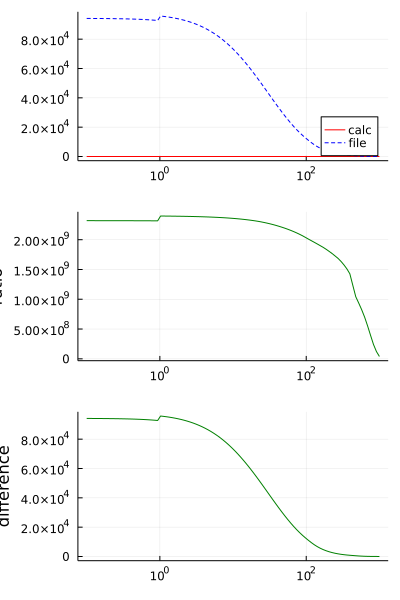

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [41]:
xs_1 = ss
xs_2 = ss
ys_1 = calc_xis
ys_2 = xis

p1 = plot(xs_1, ys_1,  label="calc", lc=:red, 
    legend=:bottomright, xaxis=:log)
plot!(p1, xs_2, ys_2, label="file", lc=:blue, ls=:dash)

p2 = plot(xs_1, ys_2 ./ ys_1, ylabel="ratio", lc=:green, 
    legend=false, xaxis=:log)
p3 = plot(xs_1, ys_2 .- ys_1, ylabel="difference", lc=:green, 
    legend=false, xaxis=:log)

plot(p1, p2, p3, layout=grid(3,1), size=(400, 600))

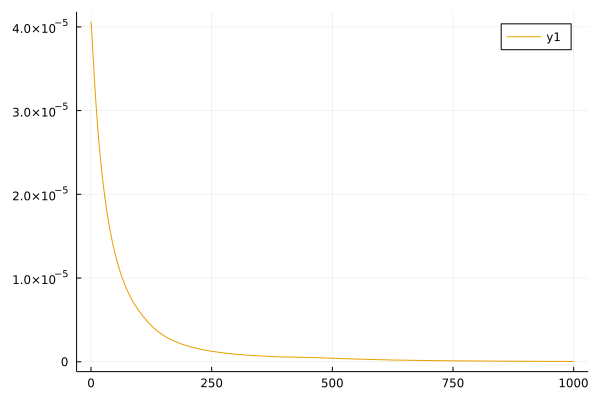

In [42]:
plot(ss, calc_xis)